# PBMC data with GSSNNG-decoupler API
We'll use **gssnng** to score the cells in the pbmc3k dataset for the `progeny` genesets in decoupler (a set of well curated genesets relating to signalling activity).

This uses `run_gssnng()` which integrates better with decoupler

In [23]:
from gssnng import score_cells, gene_sets
import decoupler as dc
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4.0, 3.0]

In [2]:
%matplotlib inline

## Get the dataset

/home/michi/miniconda3_newtry/envs/May2023/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


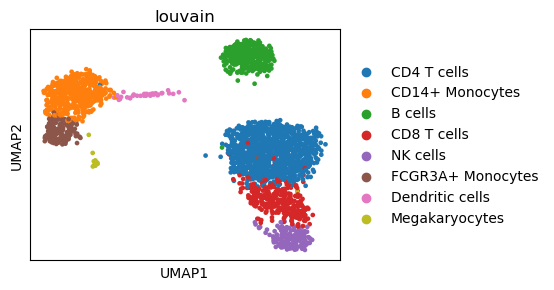

In [3]:
adata = sc.datasets.pbmc3k_processed()
sc.pl.umap(adata, color='louvain')

In [4]:
# some weirdness in the smoothing function, if adata.X is an np.array things crash
adata.X = sparse.csr_matrix(adata.X)

## Get the genesets
This is a simple DataFrame, encoding the bipartite graph `geneset-name`-> `genename`.

Note: These genesets contain genes *negatively associated* with the signature (i.e. low expression of a gene indicates the presence of a signature). We filter those out here as gssnng doesn't take into account the (negative) weight.

In [5]:
model = dc.get_progeny().query('weight>0')
model.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


# GSSNNG

In [6]:
score_cells.run_gssnng(
    adata, model, source='source',target='target', weight='weight',
    groupby=None, # "louvain",
    smooth_mode='connectivity',
    recompute_neighbors=0,
    score_method="singscore",
    method_params={'normalization':'theoretical'},
    ranked=True,
    cores=6
)

running cat1


In [7]:
acts_gss = dc.get_acts(adata, obsm_key='gssnng_estimate')

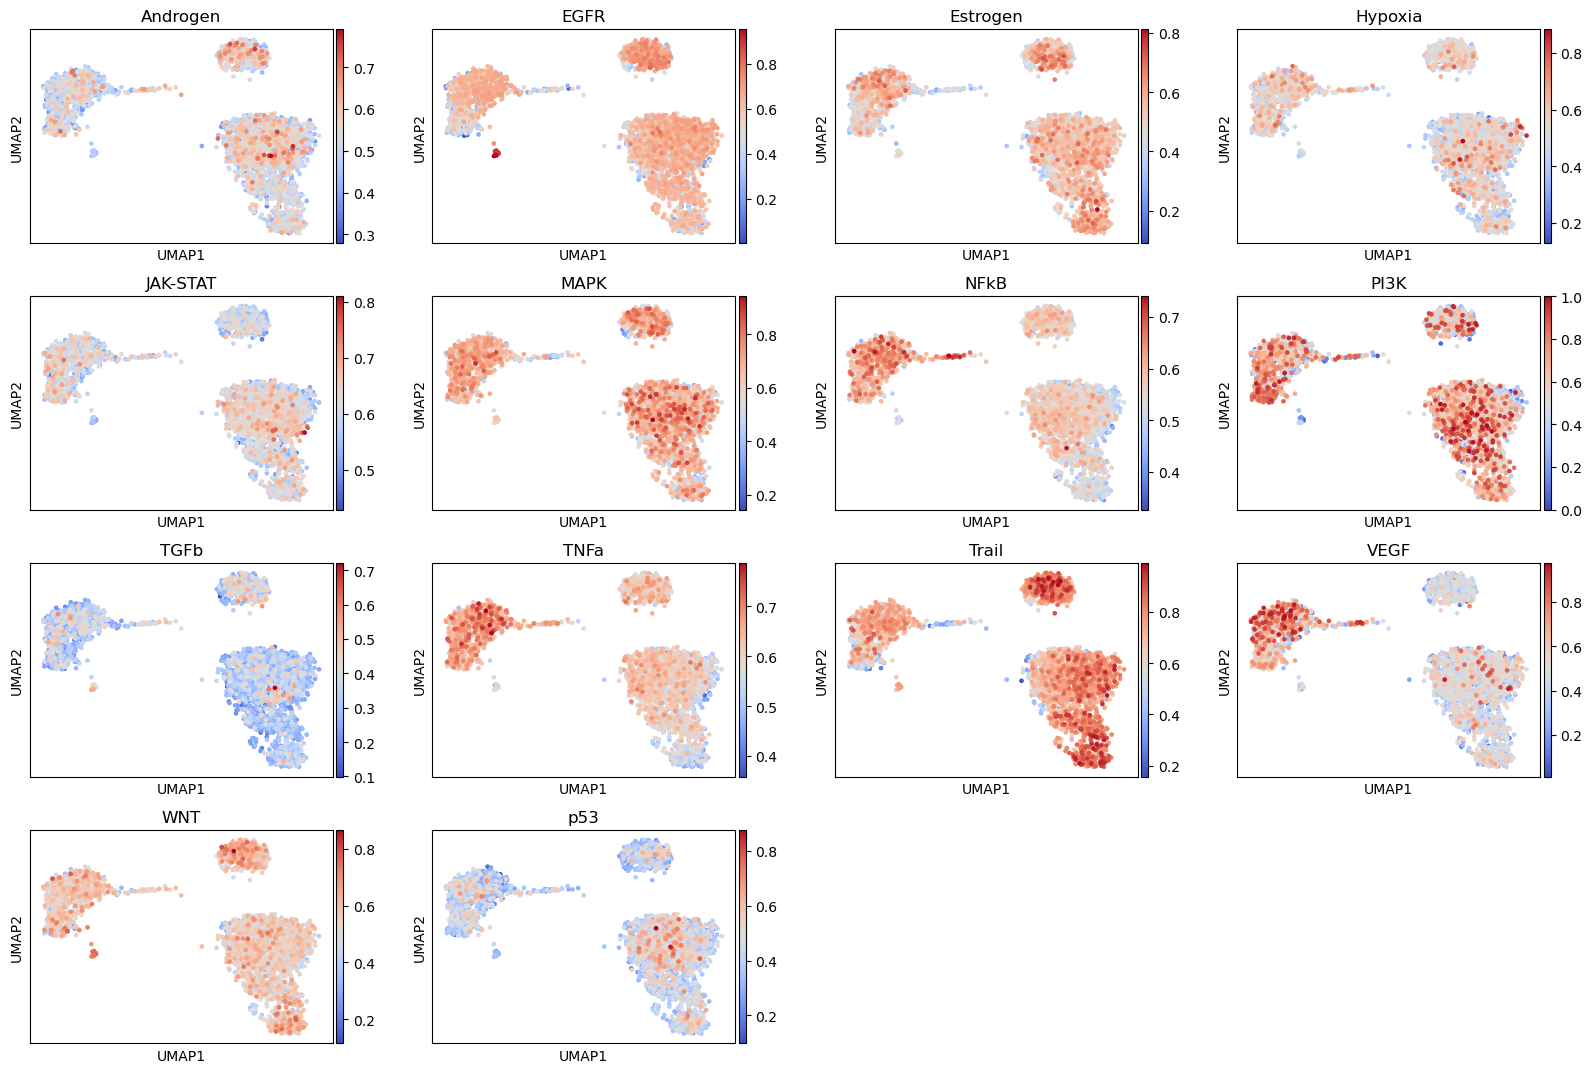

In [8]:
sc.pl.umap(acts_gss, color=sorted(acts_gss.var_names), cmap='coolwarm')

# Comparing to other methods

## MLM scoring

1 features of mat are empty, they will be removed.
Running mlm on mat with 2638 samples and 13713 targets for 13 sources.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


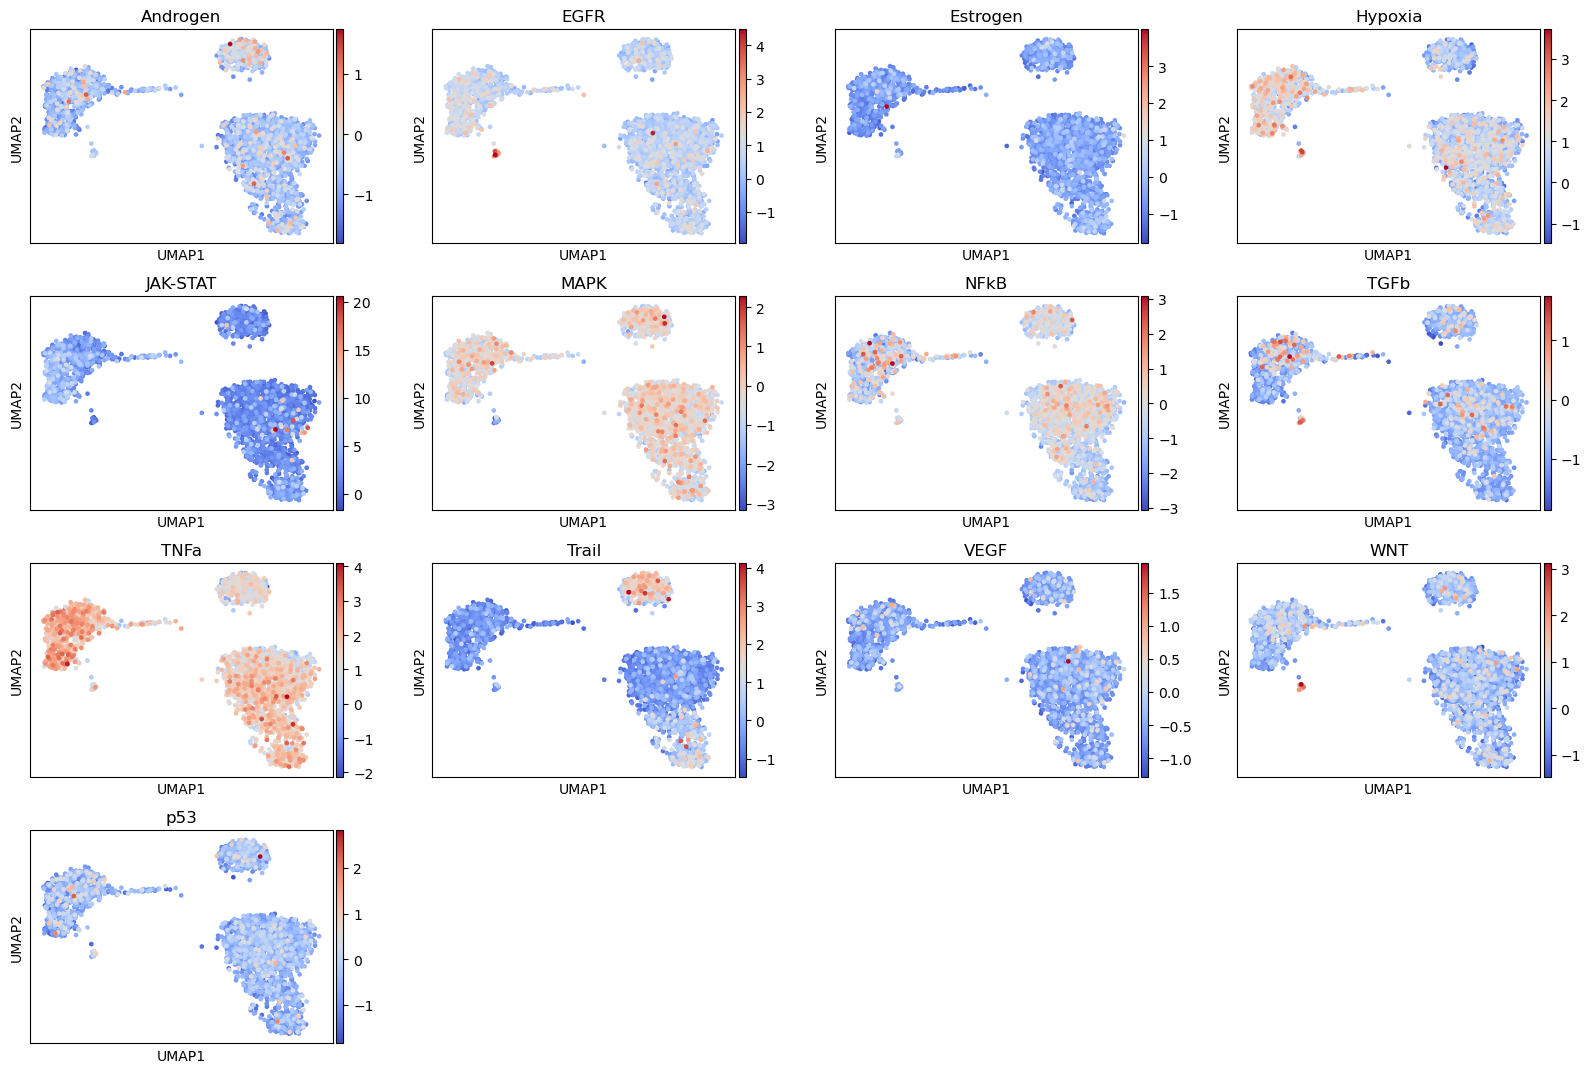

In [9]:
dc.run_mlm(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)
acts_mlm = dc.get_acts(adata, obsm_key='mlm_estimate')
sc.pl.umap(acts_mlm, color=sorted(acts_mlm.var_names),cmap='coolwarm')

## AUCell

1 features of mat are empty, they will be removed.
Running aucell on mat with 2638 samples and 13713 targets for 13 sources.


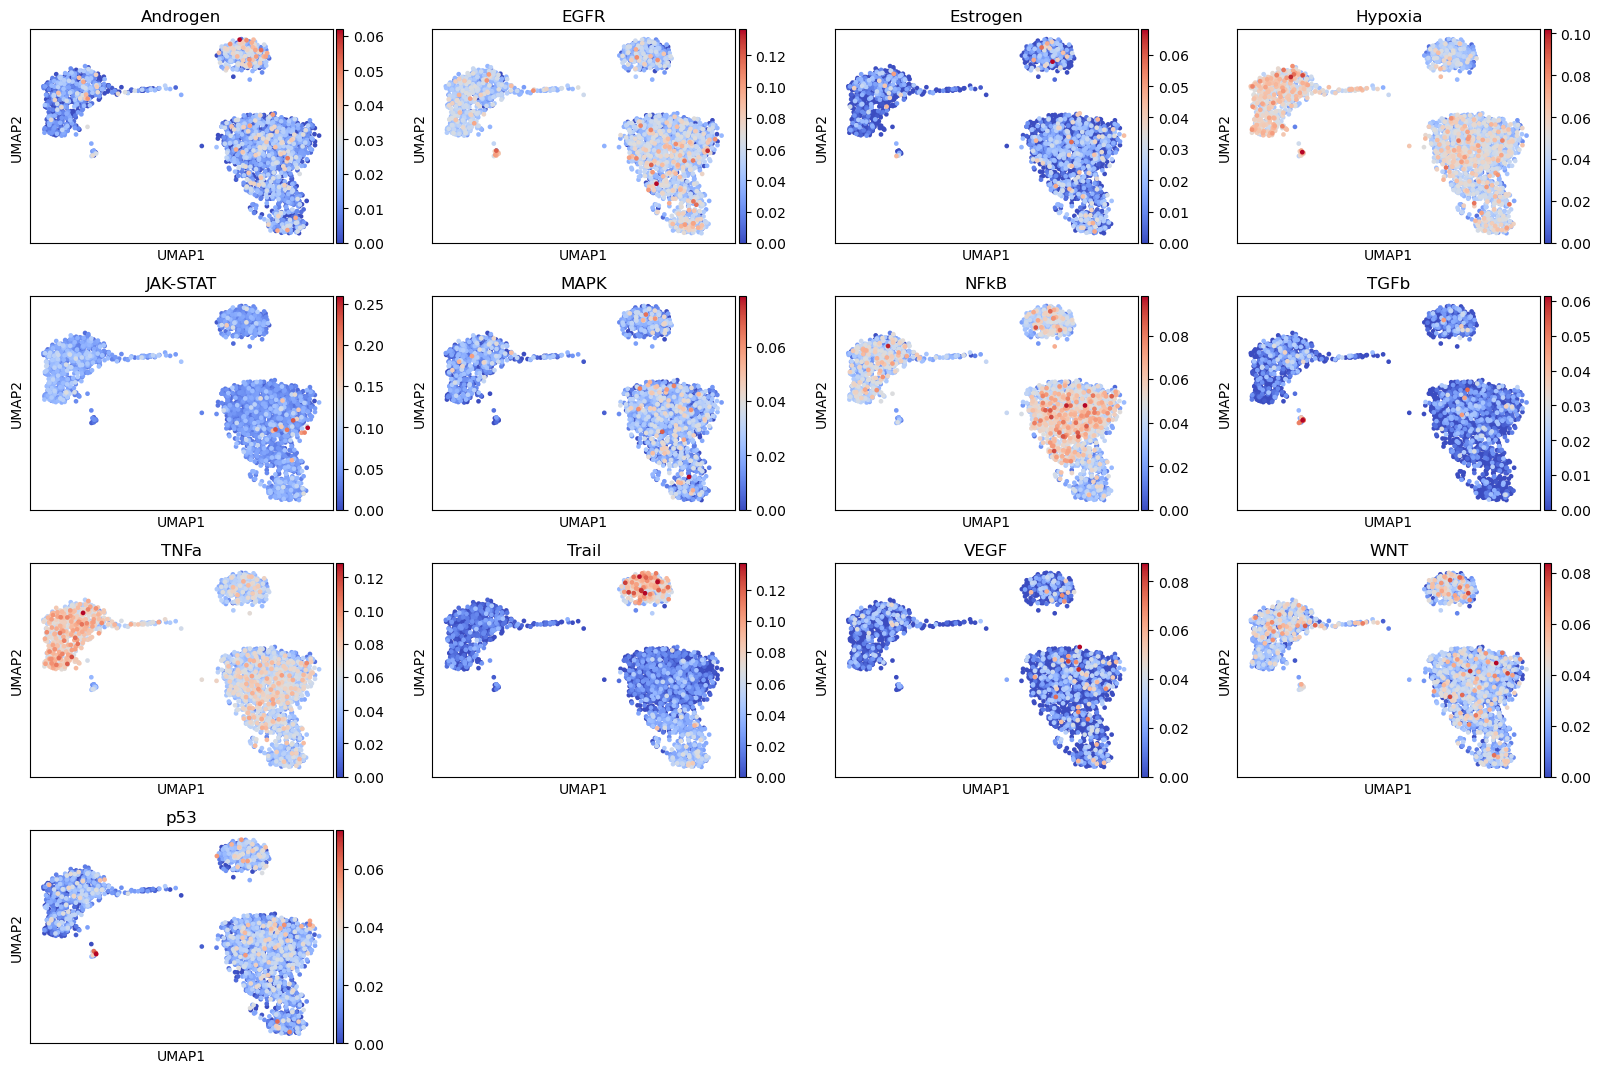

In [10]:
dc.run_aucell(mat=adata, net=model, source='source', target='target', verbose=True)
acts_aucell = dc.get_acts(adata, obsm_key='aucell_estimate')
sc.pl.umap(acts_aucell, color=sorted(acts_mlm.var_names),cmap='coolwarm')

## Wsum


1 features of mat are empty, they will be removed.
Running wsum on mat with 2638 samples and 13713 targets for 13 sources.
Infering activities on 1 batches.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.65s/it]


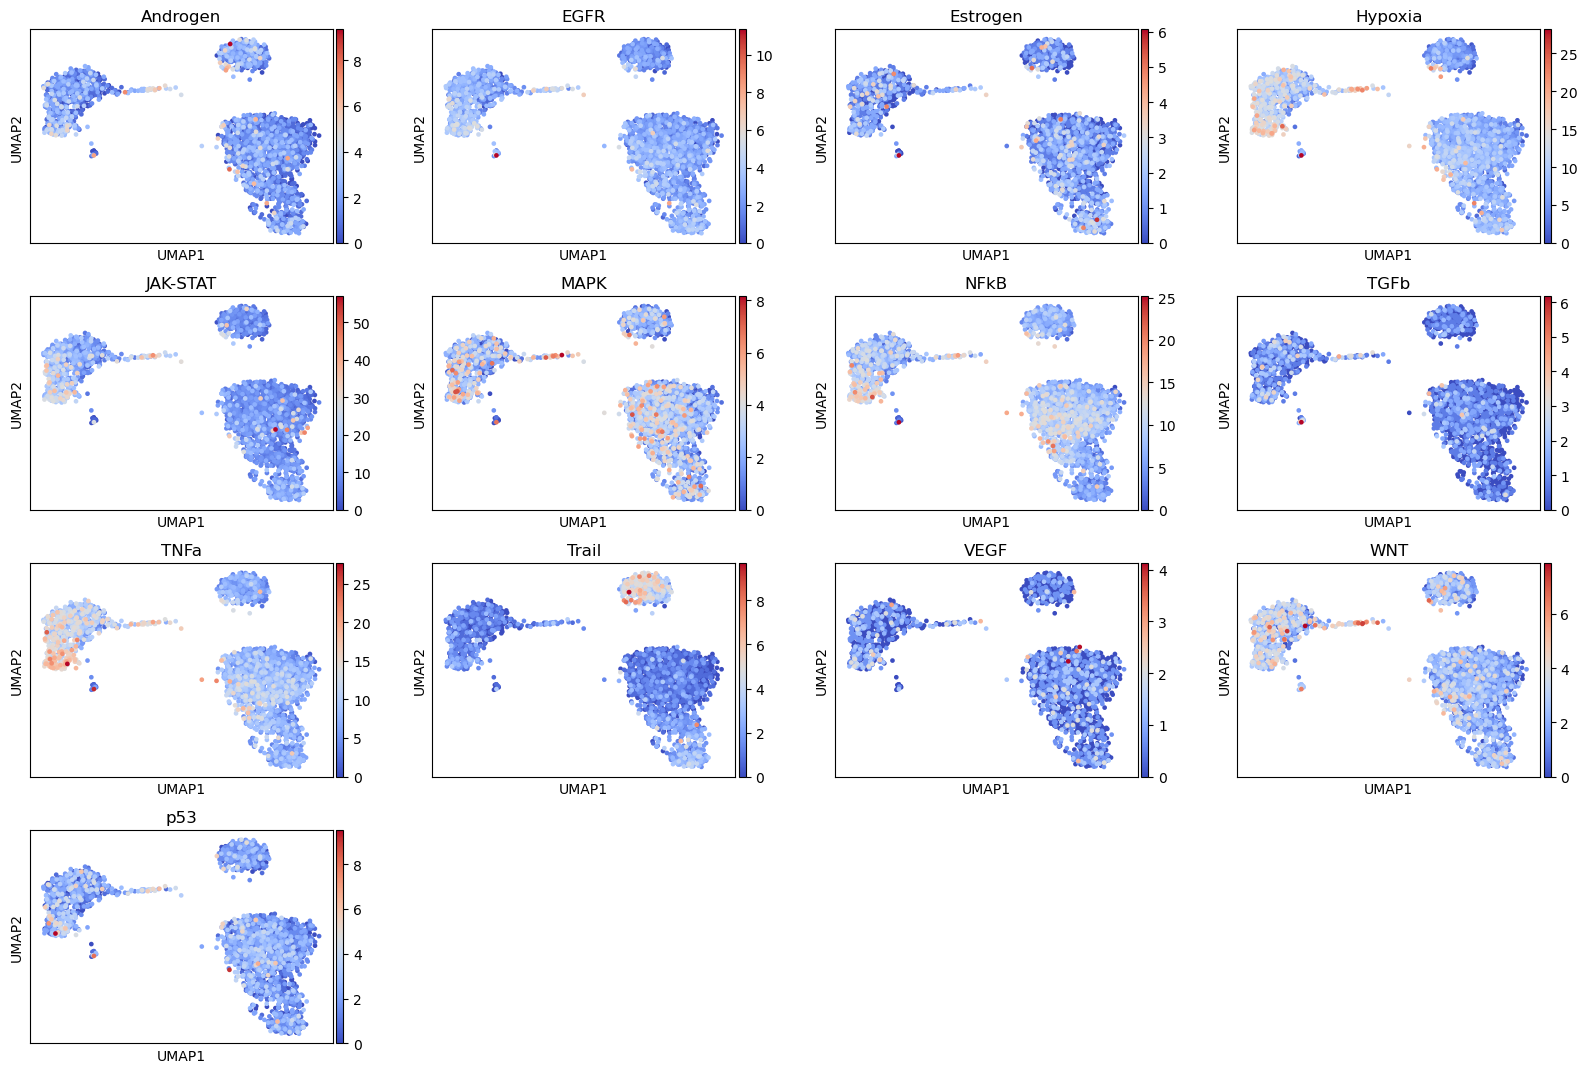

In [11]:
dc.run_wsum(mat=adata, net=model, source='source', target='target', weight=None, verbose=True)
acts_wsum = dc.get_acts(adata, obsm_key='wsum_estimate')
sc.pl.umap(acts_wsum, color=sorted(acts_mlm.var_names),cmap='coolwarm')

# Systematic comparison
for a given signature (e.g. Trail), how well do the different methods correlate (across cells)

In [16]:
from scipy import stats
import itertools
import plydata
import plotnine as pn

In [17]:
pathways = [_ for _ in model.source.unique() if _!='PI3K']  # somehow Pi3k cant be scored by all method?!

acts = {
    'gssnng': acts_gss,
    'mlm': acts_mlm, 
    'aucell': acts_aucell,
    'wsum': acts_wsum,
}

In [20]:
results = []
# for n1, n2 in itertools.combinations(acts.keys(), 2):
# for n1, n2 in itertools.combinations_with_replacement(acts.keys(), 2):
for n1, n2, pathway in itertools.product(acts.keys(), acts.keys(), pathways):
    
    a1 = acts[n1]
    a2 = acts[n2]

    r_pearson, p_pearson = stats.pearsonr(a1[:, pathway].X.flatten() ,a2[:, pathway].X.flatten())
    r_spear, p_spear = stats.spearmanr(a1[:, pathway].X.flatten(), a2[:, pathway].X.flatten())
    results.append({
        'scoring_method1': n1,
        'scoring_method2': n2,
        'r_pearson': r_pearson,
        'p_pearson': p_pearson,
        'r_spearman': r_spear,
        'p_spearman': p_spear,
        'pathway': pathway

    })
results= pd.DataFrame(results)

## Pearson correlation

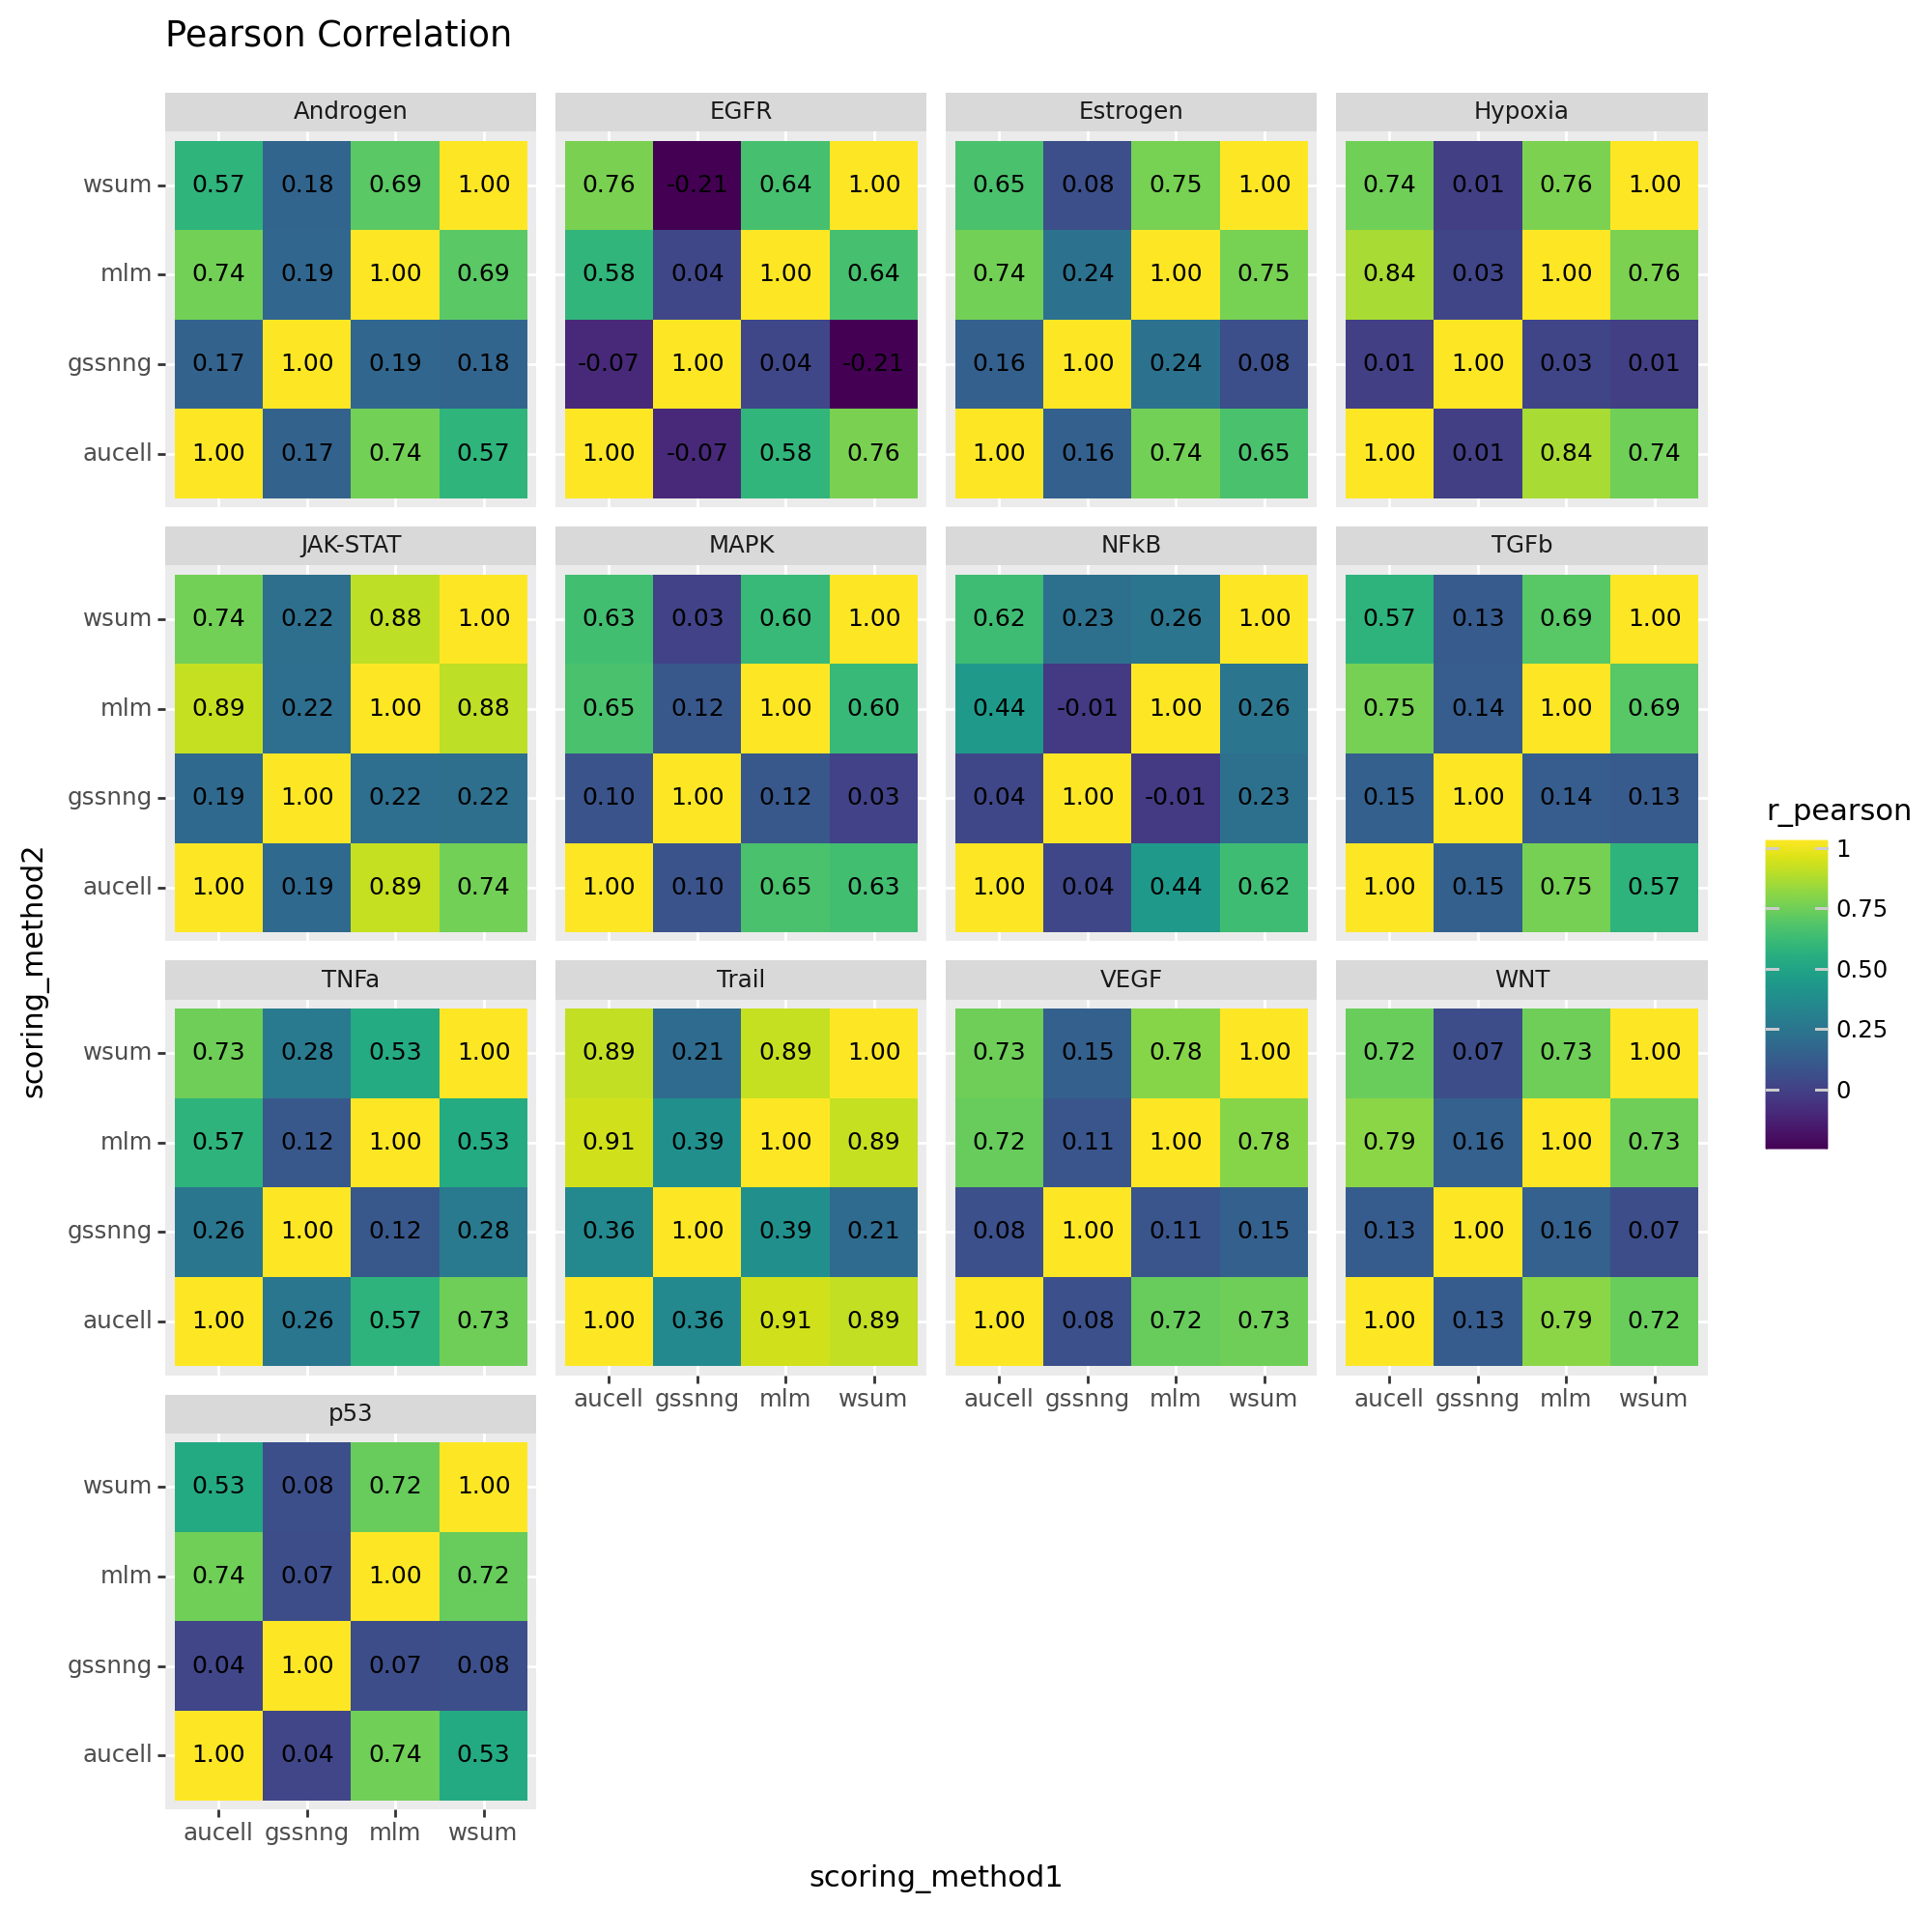

<Figure Size: (1000 x 1000)>

In [21]:
pn.ggplot(results >> plydata.define(label=results.r_pearson.apply(lambda x: f'{x:.2f}')), 
          pn.aes(x='scoring_method1', y='scoring_method2', fill='r_pearson', label='label'))\
+ pn.geom_tile()+ pn.geom_text(size=9) + pn.theme(figure_size=(10,10)) + pn.facet_wrap('pathway') + pn.labs(title='Pearson Correlation')

## Spearman correlation

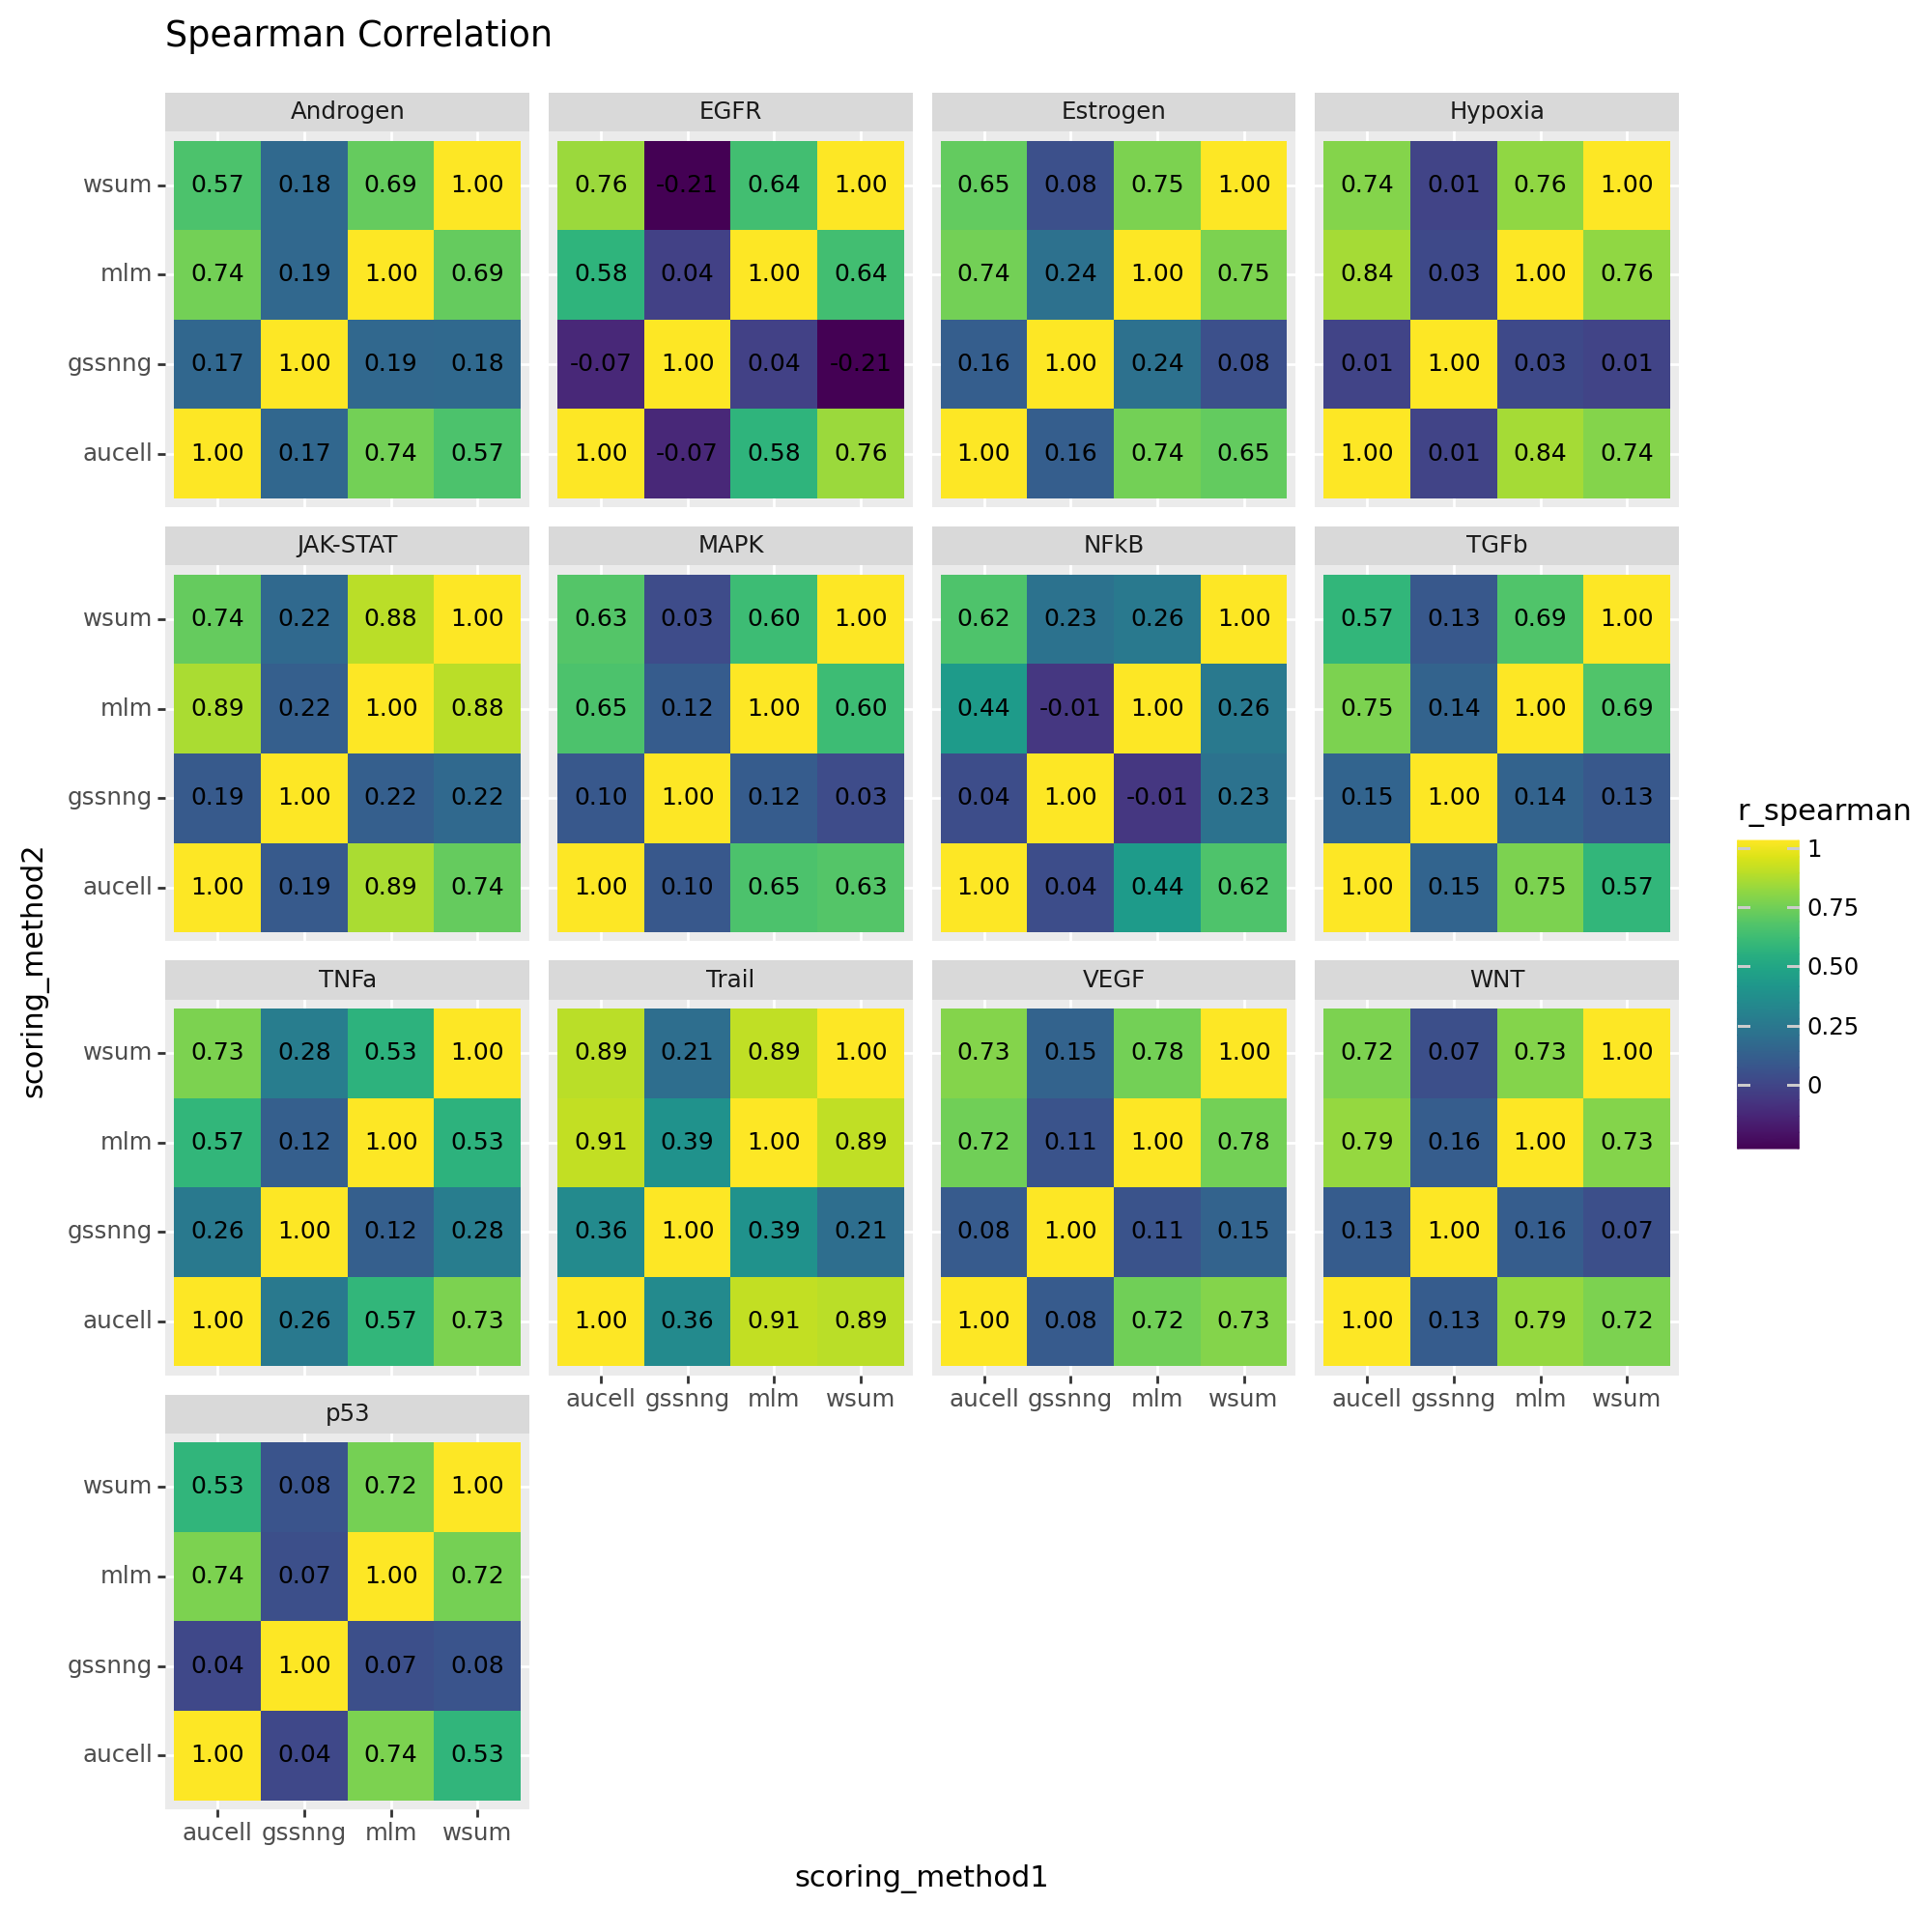

<Figure Size: (1000 x 1000)>

In [22]:
pn.ggplot(results >> plydata.define(label=results.r_pearson.apply(lambda x: f'{x:.2f}')), 
          pn.aes(x='scoring_method1', y='scoring_method2', fill='r_spearman', label='label'))\
+ pn.geom_tile()+ pn.geom_text(size=9) + pn.theme(figure_size=(10,10)) + pn.facet_wrap('pathway') + pn.labs(title='Spearman Correlation')